In [ ]:
# Run only during the first execution of this notebook
!pip install --no-cache-dir --no-build-isolation -U tifffile[all]
# !pip install --no-cache-dir --no-build-isolation torchvision # Run only if you have problems with torchvision using the loaded module from the cluster

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/apps/Arch/software/Python/3.9.5-GCCcore-10.3.0/bin/python3.9 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |█████████████████▏              | 331.5 MB 166.0 MB/s eta 0:00:02

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



     |█████████████████████████████▉  | 579.0 MB 166.7 MB/s eta 0:00:01 493.6 MB 159.2 MB/s eta 0:00:01MB 166.7 MB/s eta 0:00:01

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from PIL import Image

/cephyr/users/amirmaso/Alvis/.local/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/cephyr/users/amirmaso/Alvis/.local/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104impl8GPUTrace13gpuTraceStateE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
from torchvision.transforms.functional import InterpolationMode
import tifffile as tiff

def get_mgrid(x_dim, y_dim):
    tensors = tuple([torch.linspace(-1, 1, steps=x_dim)] + [torch.linspace(-1, 1, steps=y_dim)])
    grid = torch.stack(torch.meshgrid(*tensors, indexing="ij"), dim=-1)
    grid = grid.reshape(-1, 2)
    return grid

class MicroCTSingleImage(Dataset):
    def __init__(self, imgpath, resize_factor):
        self.img = tiff.imread(imgpath)
        self.img = self.img.astype('float32')
        H, W = int(self.img.shape[0] / resize_factor), int(self.img.shape[1] / resize_factor)
        transform = Compose([
        ToTensor(),
        Resize((H, W), interpolation=InterpolationMode.BICUBIC),
        Normalize(torch.Tensor([0]), torch.Tensor([self.img.max()]))
        ])
        self.coords = get_mgrid(H, W)
        self.coords = (self.coords - 0) / self.coords.max()
        self.img = transform(self.img)[0]

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0 or idx < -1:
            raise IndexError("Index out of range")

        return self.img, self.coords

In [3]:
from torch import nn

# SIREN paper: https://arxiv.org/pdf/2006.09661.pdf
# Sine Layer for the SIREN model
class SineLayer(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))


In [4]:
# SIREN paper: https://arxiv.org/pdf/2006.09661.pdf
# SIREN model with configurable number of layers, hidden features, and outermost linear layer
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, inputs):
        output = torch.sigmoid(self.net(inputs))
        return output, inputs

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import time
import datetime
from math import log10, sqrt

# Function to return tensor size in MB
def tensor_size(tensor):
    return tensor.element_size() * tensor.nelement() / 1024 ** 2

# Function to return model size in MB
def print_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    model_size = (param_size + buffer_size) / 1024**2
    print('Model size: {:.3f}MB'.format(model_size))

# Function to train the SIREN model on a single slice/image of the a MicroCT scan
def train_siren(model, dataloader, total_steps, steps_til_summary, device, checkpoint_path, lr=1e-6):

    # Empty CUDA cache
    torch.cuda.empty_cache()

    # Load data
    img, coords = next(iter(dataloader))
    H, W = img.squeeze(0).shape

    # Move data to GPU
    img = img.squeeze(0).view(-1, 1).to(device)
    coords = coords.squeeze(0).to(device)

    # Define optimizer
    optimizer = torch.optim.Adam(lr=lr, params=model.parameters())
    model.train()
    model.zero_grad()

    # Define loss function
    loss_fn = torch.nn.MSELoss()

    # Train
    start_time = time.time()
    max_loss = 1.0
    for step in range(total_steps):
        img_pred, coords = model(coords)
        loss = loss_fn(img_pred, img)

        loss.backward()

        optimizer.step()

        model.zero_grad()

        if step % steps_til_summary == 0:
            print(f"Step {step}, Total loss {loss:.6f}")
            if loss.item() < max_loss:
              print("Best new model! Saving...")
              best_model = model
              max_loss = loss.item()
              torch.save(model.state_dict(), checkpoint_path)

            # Show predicted image and ground truth image so far
            model_img = img_pred.cpu().view(H,W).detach().numpy()
            gt_img = img.cpu().view(H,W).detach().numpy()

            plt.imshow(model_img, cmap="gray")
            plt.show()
            plt.imshow(gt_img, cmap="gray")
            plt.show()


    print(f'Training finished, took {datetime.timedelta(seconds=time.time() - start_time)}')
    print(f'Best error achieved: {max_loss:.6f}')

    return best_model

# Function to evaluate the SIREN model on the single slice/image of the a MicroCT scan
def evaluate_siren(model, img, coords, device, imagepath='pred.png'):

    H, W = img.squeeze(0).shape
    img = img.squeeze(0).view(-1, 1)

    # Move input to GPU
    img = img.to(device)
    coords = coords.squeeze(0).to(device)

    # Get model prediction
    model.eval()
    img_pred, coords = model(coords)

    # Calculate the loss
    mse = torch.nn.MSELoss()
    mse = mse(img_pred, img).item()
    psnr = 20 * log10(img.max() / sqrt(mse))

    # Show predicted image and ground truth image so far
    model_img = img_pred.cpu().view(H,W).detach().numpy()
    gt_img = img.cpu().view(H,W).detach().numpy()

    f, ax = plt.subplots(1,2)
    ax[0].axis('off')
    ax[0].set_title('Neural Representation')
    ax[0].imshow(model_img, cmap="gray")
    ax[1].axis('off')
    ax[1].set_title('Original')
    ax[1].imshow(gt_img, cmap="gray")
    f.show()

    # Save prediction image
    plt.imsave(imagepath, model_img, cmap="gray")

    print(f'The resulting MSE: {mse:.6f} and PSNR: {psnr}')

    return img_pred


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Step 0, Total loss 0.018229
Best new model! Saving...


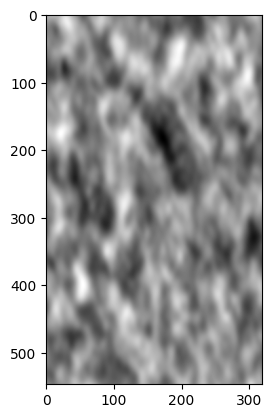

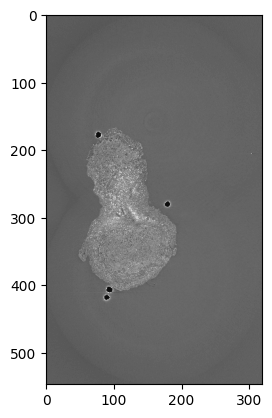

Step 100, Total loss 0.001132
Best new model! Saving...


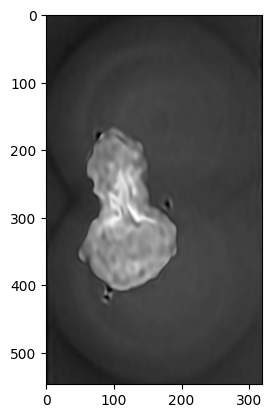

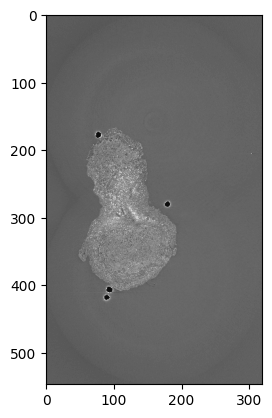

Step 200, Total loss 0.000974
Best new model! Saving...


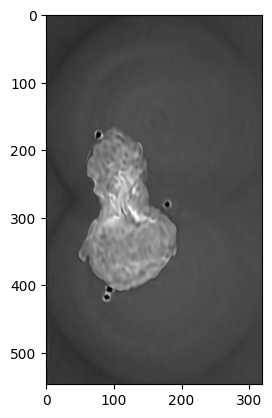

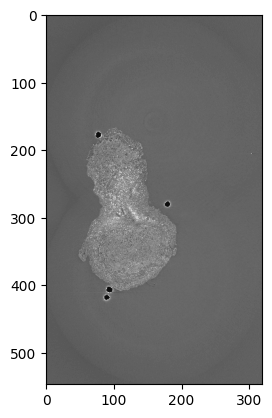

Step 300, Total loss 0.000827
Best new model! Saving...


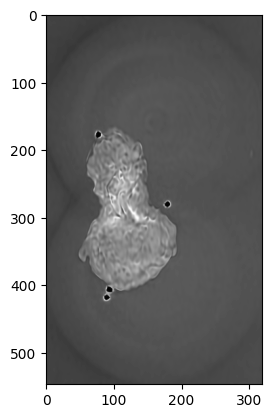

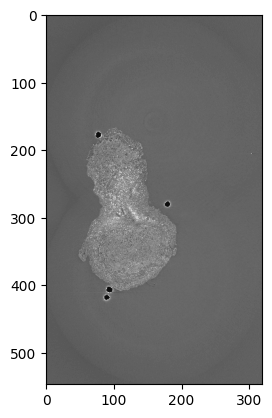

Step 400, Total loss 0.000700
Best new model! Saving...


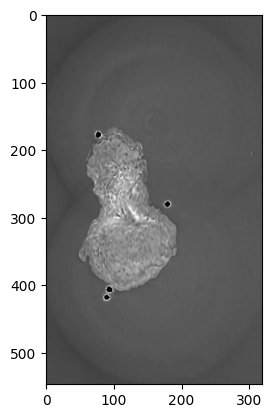

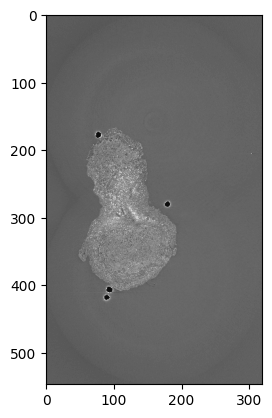

Step 500, Total loss 0.000551
Best new model! Saving...


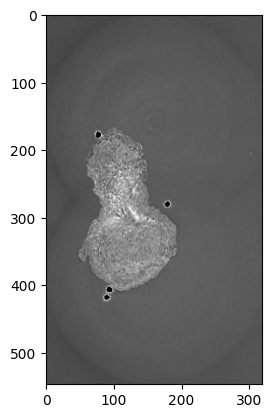

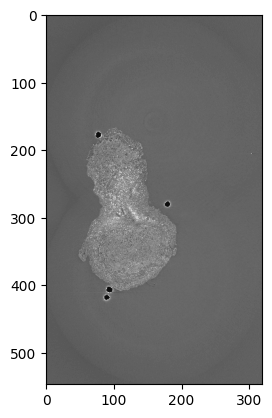

Step 600, Total loss 0.000369
Best new model! Saving...


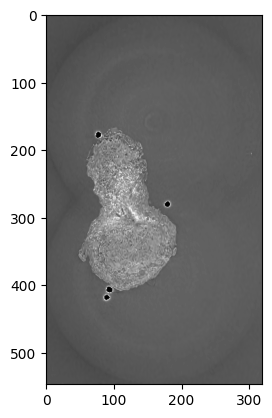

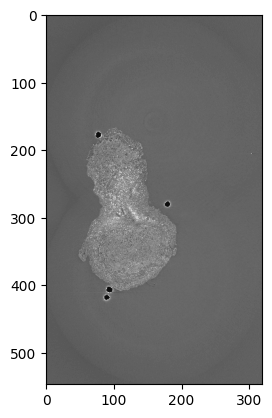

Step 700, Total loss 0.000240
Best new model! Saving...


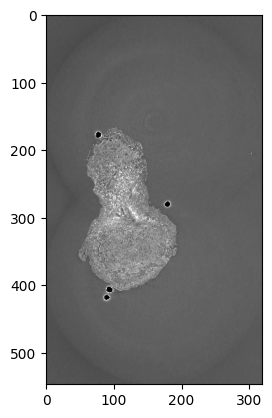

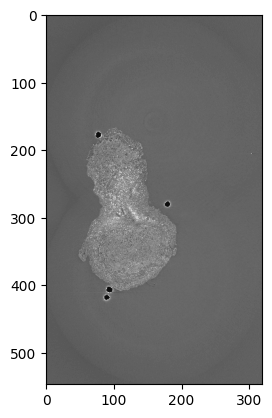

Step 800, Total loss 0.000155
Best new model! Saving...


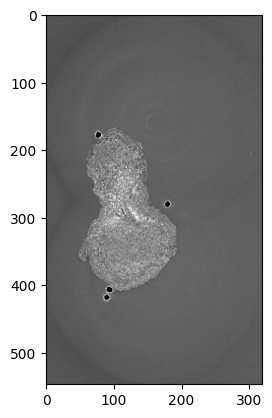

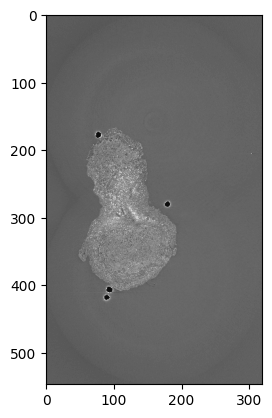

Step 900, Total loss 0.000100
Best new model! Saving...


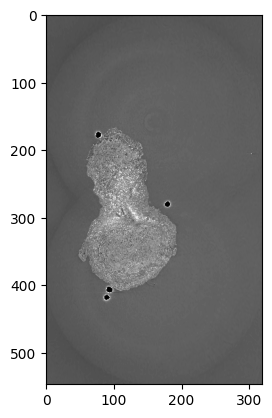

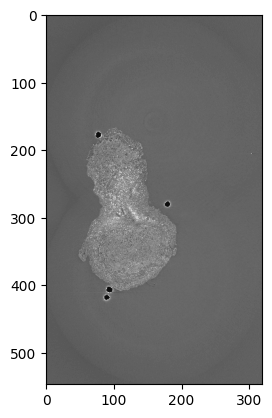

Step 1000, Total loss 0.000069
Best new model! Saving...


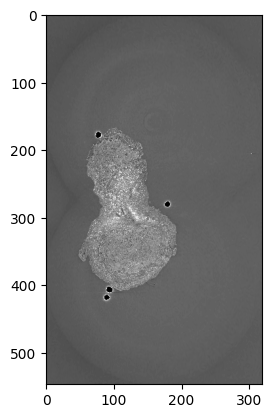

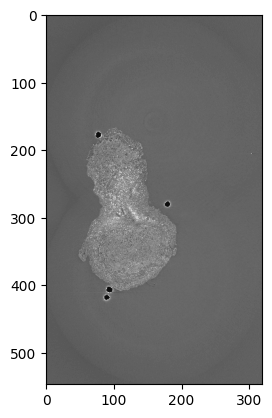

Step 1100, Total loss 0.000054
Best new model! Saving...


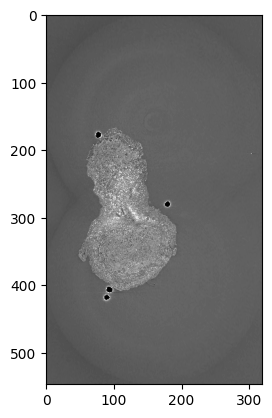

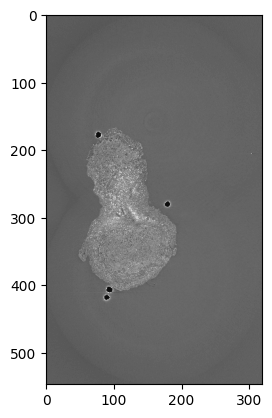

Step 1200, Total loss 0.000055


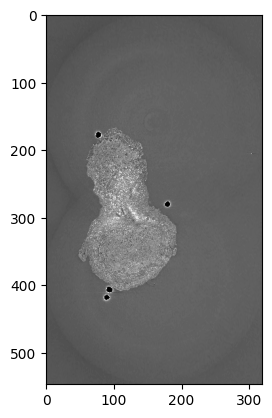

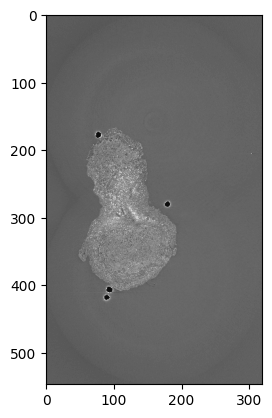

Step 1300, Total loss 0.000044
Best new model! Saving...


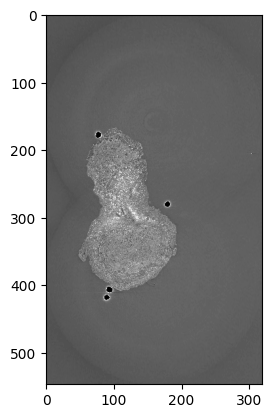

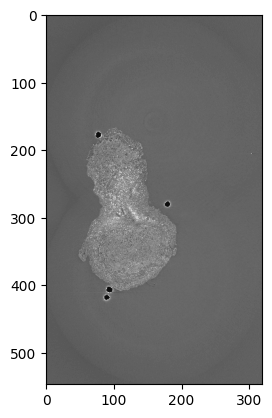

Step 1400, Total loss 0.000042
Best new model! Saving...


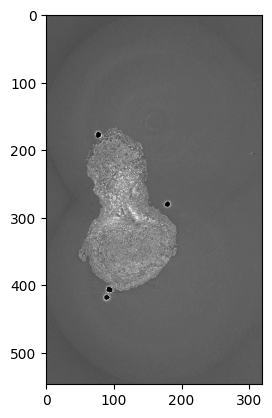

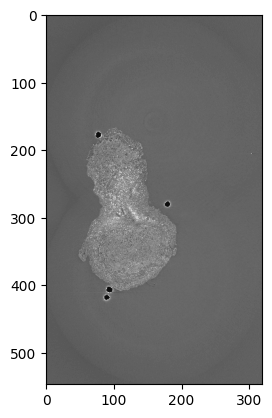

Step 1500, Total loss 0.000039
Best new model! Saving...


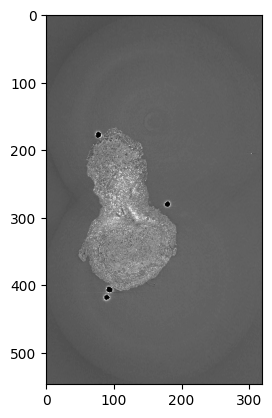

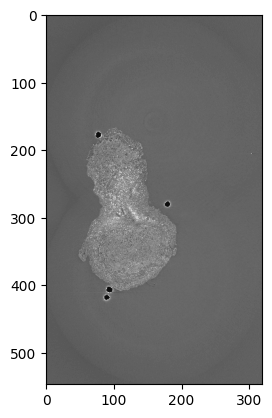

Step 1600, Total loss 0.000035
Best new model! Saving...


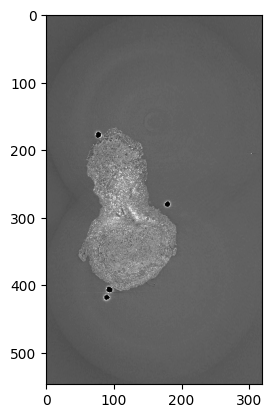

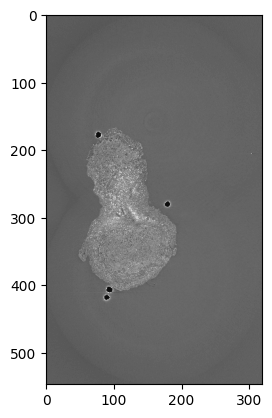

Step 1700, Total loss 0.000042


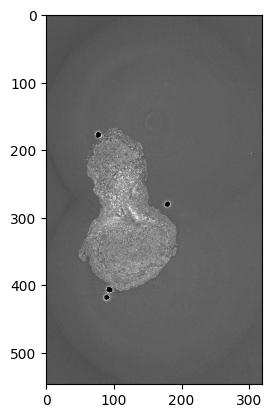

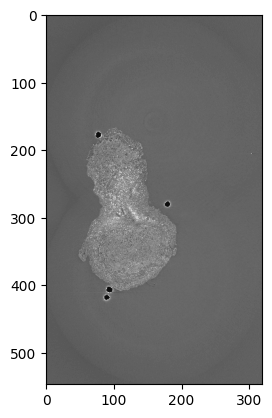

Step 1800, Total loss 0.000030
Best new model! Saving...


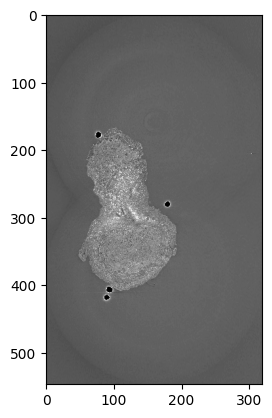

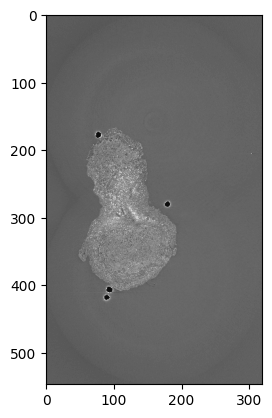

KeyboardInterrupt: ignored

In [ ]:
filename = "./174_tumor_Nr56_x4_StitchPag_stitch_2563x4381x2162-11396.tif"

# Import dataset
dataset = MicroCTSingleImage(filename, 8)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

# Import model
model = Siren(in_features=2, out_features=1, hidden_features=384, hidden_layers=4, outermost_linear=True)

# Move model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.cuda.empty_cache()

# Train model
model = train_siren(model, dataloader, total_steps=5500, lr=1e-4, steps_til_summary=100, device=device, checkpoint_path=f'{filename[-9:-4]}_checkpoint.pt')

In [8]:
# Load trained model from checkpoint for evaluation
PATH = "11396_checkpoint.pt"
model = Siren(in_features=2, out_features=1, hidden_features=384, hidden_layers=4, outermost_linear=True)

model.load_state_dict(torch.load(PATH))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.cuda.empty_cache()

model.eval()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=384, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=384, out_features=384, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=384, out_features=384, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=384, out_features=384, bias=True)
    )
    (4): SineLayer(
      (linear): Linear(in_features=384, out_features=384, bias=True)
    )
    (5): Linear(in_features=384, out_features=1, bias=True)
  )
)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


The resulting MSE: 0.000002 and PSNR: 56.720554418552354


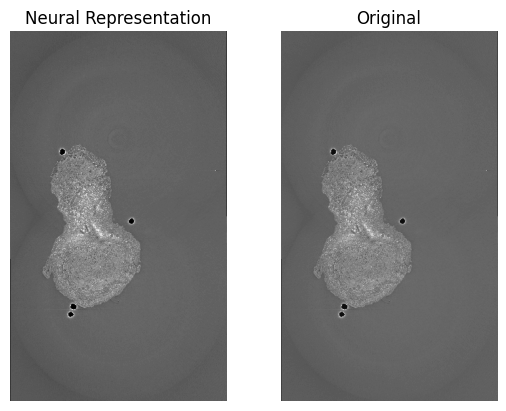

In [ ]:
# Save final prediction image
filename = "./174_tumor_Nr56_x4_StitchPag_stitch_2563x4381x2162-11396.tif"
dataset = MicroCTSingleImage(filename, 8)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

img, coords = next(iter(dataloader))

res = evaluate_siren(model, img, coords, device)

In [9]:
# Evaluate model in the original resolution

# Function to evaluate the input on the SIREN partially in batches
# (useful for when the input does not fit on the GPU completely)
def evaluate_siren_partial(model, img, coords, device, batch_size=100, imagepath='pred.png'):
    H, W = img.squeeze(0).shape
    img = img.squeeze(0).view(-1, 1)

    coords = coords.squeeze(0)

    coord_batches = np.array_split(coords, (coords.shape[0] / batch_size))

    img_pred = torch.empty(coords.shape[0], 1)

    i = 0
    for coord_batch in coord_batches:

      # Move input to GPU
      torch.cuda.empty_cache()
      coord_batch = coord_batch.to(device)

      # Get model prediction
      model.eval()
      pred, coord_batch = model(coord_batch)

      img_pred[i:i+len(coord_batch)] = pred.cpu().detach()
      i = i + len(coord_batch)

    # Calculate the loss
    mse = torch.nn.MSELoss()
    mse = mse(img_pred, img).item()
    psnr = 20 * log10(img.max() / sqrt(mse))

    # Show predicted image and ground truth image so far
    model_img = img_pred.view(H,W).numpy()
    gt_img = img.view(H,W).numpy()

    f, ax = plt.subplots(1,2)
    ax[0].axis('off')
    ax[0].set_title('Neural Representation')
    ax[0].imshow(model_img, cmap="gray")
    ax[1].axis('off')
    ax[1].set_title('Original')
    ax[1].imshow(gt_img, cmap="gray")
    f.show()

    # Save prediction image
    plt.imsave(imagepath, model_img, cmap="gray")

    print(f'The resulting MSE: {mse:.6f} and PSNR: {psnr}')

    return img_pred

/cephyr/users/amirmaso/Alvis/.local/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


The resulting MSE: 0.000377 and PSNR: 34.235291417831185


tensor([[0.3633],
        [0.3557],
        [0.3530],
        ...,
        [0.3744],
        [0.3757],
        [0.3792]])

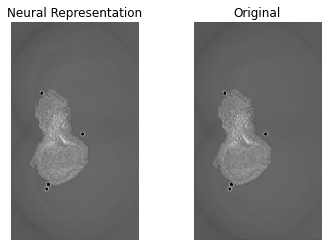

In [10]:
filename = "./174_tumor_Nr56_x4_StitchPag_stitch_2563x4381x2162-11396.tif"

# Load image again in original resolution
dataset = MicroCTSingleImage(filename, 1)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)
img, coords = next(iter(dataloader))

evaluate_siren_partial(model, img, coords, device, imagepath='pred_original_res.png')

In [8]:
# Function to train the SIREN model on a single slice/image of the a MicroCT scan using random samples
def train_siren_rand_samples(model, dataloader, total_steps, steps_til_summary, device, checkpoint_path, n_samples=1000000, lr=1e-6):

    # Empty CUDA cache
    torch.cuda.empty_cache()

    # Load data
    img, coords = next(iter(dataloader))
    img = img.squeeze(0)
    coords = coords.squeeze(0)
    H, W = img.shape

    # Define optimizer
    optimizer = torch.optim.Adam(lr=lr, params=model.parameters())
    model.train()
    model.zero_grad()

    # Define loss function
    loss_fn = torch.nn.MSELoss()

    # Train
    start_time = time.time()
    max_loss = 1.0
    for step in range(total_steps):

        print("Generating random samples...")
        # Take random samples
        idx = np.random.choice(coords.shape[0], n_samples, replace=False)
        print("Done")

        # Move data to GPU
        pixels = img.view(-1, 1)[idx].to(device)
        input_coords = coords[idx].to(device)

        # Get Model Prediction
        pred_pixels, _ = model(input_coords)
        loss = loss_fn(pred_pixels, pixels)

        # Optimize
        loss.backward()

        optimizer.step()

        model.zero_grad()

        if step % steps_til_summary == 0:
            print(f"Step {step}, Total loss {loss:.6f}")
            if loss.item() < max_loss:
              print("Best new model! Saving...")
              best_model = model
              max_loss = loss.item()
              torch.save(model.state_dict(), checkpoint_path)

            # Show predicted image and ground truth image so far
            # model_img = img_pred.cpu().view(H,W).detach().numpy()
            # gt_img = img.cpu().view(H,W).detach().numpy()

            # plt.imshow(model_img, cmap="gray")
            # plt.show()
            # plt.imshow(gt_img, cmap="gray")
            # plt.show()


    print(f'Training finished, took {datetime.timedelta(seconds=time.time() - start_time)}')
    print(f'Best error achieved: {max_loss:.6f}')

    return best_model

In [ ]:
filename = "./174_tumor_Nr56_x4_StitchPag_stitch_2563x4381x2162-11396.tif"

# Import dataset in original resolution
dataset = MicroCTSingleImage(filename, 1)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

# Import model
model = Siren(in_features=2, out_features=1, hidden_features=384, hidden_layers=4, outermost_linear=True)

# Move model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.cuda.empty_cache()


# Train model
model = train_siren_rand_samples(model, dataloader, total_steps=30000, lr=1e-4, steps_til_summary=100, n_samples=18000, device=device, checkpoint_path=f'{filename[-9:-4]}_checkpoint_rand_samp.pt')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Step 0, Total loss 0.016565
Best new model! Saving...
Step 100, Total loss 0.001347
Best new model! Saving...
Step 200, Total loss 0.001339
Best new model! Saving...
Step 300, Total loss 0.001271
Best new model! Saving...
Step 400, Total loss 0.001189
Best new model! Saving...
Step 500, Total loss 0.001135
Best new model! Saving...
Step 600, Total loss 0.001060
Best new model! Saving...
Step 700, Total loss 0.001240
Step 800, Total loss 0.001175
Step 900, Total loss 0.001136
Step 1000, Total loss 0.001065
Step 1100, Total loss 0.001079
Step 1200, Total loss 0.001036
Best new model! Saving...
Step 1300, Total loss 0.001154
Step 1400, Total loss 0.001066
Step 1500, Total loss 0.001120
Step 1600, Total loss 0.000981
Best new model! Saving...
Step 1700, Total loss 0.001048
Step 1800, Total loss 0.001013
Step 1900, Total loss 0.001008
Step 2000, Total loss 0.001092
Step 2100, Total loss 0.000936
Best new model! Saving...
Step 2200, Total loss 0.001070
Step 2300, Total loss 0.001061
Step 240

In [ ]:
# Load trained model from checkpoint for evaluation
PATH = "11396_checkpoint_rand_samp.pt"
model = Siren(in_features=2, out_features=1, hidden_features=384, hidden_layers=4, outermost_linear=True)

model.load_state_dict(torch.load(PATH))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.cuda.empty_cache()

model.eval()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=384, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=384, out_features=384, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=384, out_features=384, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=384, out_features=384, bias=True)
    )
    (4): SineLayer(
      (linear): Linear(in_features=384, out_features=384, bias=True)
    )
    (5): Linear(in_features=384, out_features=1, bias=True)
  )
)

The resulting MSE: 0.000995 and PSNR: 30.019845355154157


tensor([[0.2870],
        [0.2962],
        [0.3036],
        ...,
        [0.3483],
        [0.3499],
        [0.3517]])

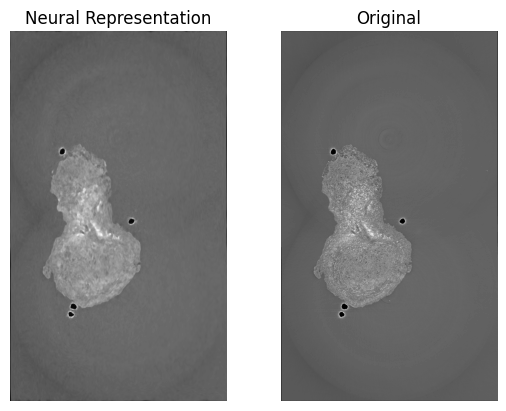

In [ ]:
# Load image again in original resolution
filename = "./174_tumor_Nr56_x4_StitchPag_stitch_2563x4381x2162-11396.tif"
dataset = MicroCTSingleImage(filename, 1)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)
img, coords = next(iter(dataloader))

evaluate_siren_partial(model, img, coords, device, imagepath='pred_original_res.png')

In [9]:
class MicroCTSingleImagePatches(Dataset):
    def __init__(self, imgpath, resize_factor, patch_size=400):
        self.img = tiff.imread(imgpath)
        self.img = self.img.astype('float32')
        H, W = int(self.img.shape[0] / resize_factor), int(self.img.shape[1] / resize_factor)
        transform = Compose([
        ToTensor(),
        Resize((H, W), interpolation=InterpolationMode.BICUBIC),
        Normalize(torch.Tensor([0]), torch.Tensor([self.img.max()]))
        ])
        self.coords = get_mgrid(H, W)
        self.coords = (self.coords - 0) / self.coords.max()
        self.img = transform(self.img)[0]

        self.img = self.img.squeeze(0).view(-1, 1)
        self.coords = self.coords.squeeze(0)

        self.patch_size = patch_size

    def __len__(self):
        # print(self.img.shape[0])
        # print(ceil(self.img.shape[0] / self.patch_size))
        return self.img.shape[0] // self.patch_size

    def __getitem__(self, idx):
        start_idx = idx * self.patch_size
        end_idx = (idx + 1) * self.patch_size
        img_slice = self.img[start_idx:end_idx]
        coords_slice = self.coords[start_idx:end_idx]
        return img_slice, coords_slice


# Function to train the SIREN model on a single slice/image of the a MicroCT scan in patches of the picture
def train_siren_patches(model, dataloader, epochs, total_steps, steps_til_summary, device, checkpoint_path, lr=1e-6):

    # Empty CUDA cache
    torch.cuda.empty_cache()

    # Define optimizer
    optimizer = torch.optim.Adam(lr=lr, params=model.parameters())
    model.train()
    model.zero_grad()

    # Define loss function
    loss_fn = torch.nn.MSELoss()

    # Train
    start_time = time.time()
    max_loss = 1.0
    step = 0
    for epoch in range(epochs):

      for batch in dataloader:

        # Load data
        pixels, coords = batch

        # Move data to GPU
        img = pixels.to(device)
        coords = coords.to(device)

        img_pred, _ = model(coords)
        loss = loss_fn(img_pred, img)

        loss.backward()

        optimizer.step()

        model.zero_grad()

        if step % steps_til_summary == 0:
            print(f"Step {step}, Total loss {loss:.6f}")
            if loss.item() < max_loss:
              print("Best new model! Saving...")
              best_model = model
              max_loss = loss.item()
              torch.save(model.state_dict(), checkpoint_path)

            # Show predicted image and ground truth image so far
            # model_img = img_pred.cpu().view(H,W).detach().numpy()
            # gt_img = img.cpu().view(H,W).detach().numpy()

            # plt.imshow(model_img, cmap="gray")
            # plt.show()
            # plt.imshow(gt_img, cmap="gray")
            # plt.show()

        step += 1


    print(f'Training finished, took {datetime.timedelta(seconds=time.time() - start_time)}')
    print(f'Best error achieved: {max_loss:.6f}')

    return best_model

In [ ]:
filename = "./174_tumor_Nr56_x4_StitchPag_stitch_2563x4381x2162-11396.tif"

# Import dataset in original resolution in patches
dataset = MicroCTSingleImagePatches(filename, 1, patch_size=400)
dataloader = DataLoader(dataset, batch_size=40, shuffle=True, num_workers=0)

# Import model
model = Siren(in_features=2, out_features=1, hidden_features=384, hidden_layers=4, outermost_linear=True)

# Move model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.cuda.empty_cache()

# Train model
model = train_siren_patches(model, dataloader, epochs=200, total_steps=10000, lr=1e-4, steps_til_summary=100, device=device, checkpoint_path=f'{filename[-9:-4]}_checkpoint_patches.pt')

Step 0, Total loss 0.015332
Best new model! Saving...
Step 100, Total loss 0.002111
Best new model! Saving...
Step 200, Total loss 0.002355
Step 300, Total loss 0.001216
Best new model! Saving...
Step 400, Total loss 0.001379
Step 500, Total loss 0.000690
Best new model! Saving...
Step 600, Total loss 0.002365
Step 700, Total loss 0.001835
Step 800, Total loss 0.002532
Step 900, Total loss 0.000814
Step 1000, Total loss 0.001703
Step 1100, Total loss 0.001414
Step 1200, Total loss 0.000939
Step 1300, Total loss 0.001152
Step 1400, Total loss 0.001208
Step 1500, Total loss 0.001930
Step 1600, Total loss 0.001392
Step 1700, Total loss 0.000959
Step 1800, Total loss 0.001479
Step 1900, Total loss 0.001729
Step 2000, Total loss 0.001422
Step 2100, Total loss 0.001297
Step 2200, Total loss 0.002057
Step 2300, Total loss 0.001183
Step 2400, Total loss 0.001323
Step 2500, Total loss 0.001373
Step 2600, Total loss 0.001687
Step 2700, Total loss 0.001191
Step 2800, Total loss 0.002046
Step 2900

In [ ]:
# Load trained model from checkpoint for evaluation
PATH = "11396_checkpoint_patches.pt"
model = Siren(in_features=2, out_features=1, hidden_features=384, hidden_layers=4, outermost_linear=True)

model.load_state_dict(torch.load(PATH))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.cuda.empty_cache()

model.eval()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=384, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=384, out_features=384, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=384, out_features=384, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=384, out_features=384, bias=True)
    )
    (4): SineLayer(
      (linear): Linear(in_features=384, out_features=384, bias=True)
    )
    (5): Linear(in_features=384, out_features=1, bias=True)
  )
)

The resulting MSE: 0.001360 and PSNR: 28.66376623097171


tensor([[0.3365],
        [0.3364],
        [0.3368],
        ...,
        [0.3767],
        [0.3812],
        [0.3805]])

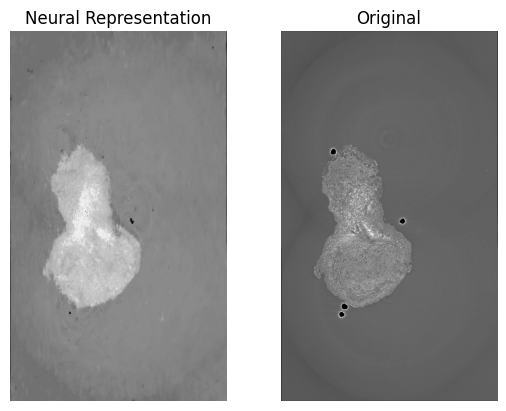

In [ ]:
# Load image again in original resolution
dataset = MicroCTSingleImage(filename, 1)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)
img, coords = next(iter(dataloader))

evaluate_siren_partial(model, img, coords, device, imagepath='pred_original_res.png')

In [6]:
################################ TEST #########################

# !pip install --no-cache-dir --no-build-isolation torchinfo

def train_siren_test(model, dataloader, total_steps, steps_til_summary, device, checkpoint_path, lr=1e-6):

    # Empty CUDA cache
    torch.cuda.empty_cache()

    # Load data
    img, coords = next(iter(dataloader))
    H, W = img.squeeze(0).shape

    # Move data to GPU
    img = img.squeeze(0).view(-1, 1).to(device)
    coords = coords.squeeze(0).to(device)

    print("1. After Input to Device: ", torch.cuda.memory_allocated(device) / (1024**2))

    # Define optimizer
    optimizer = torch.optim.Adam(lr=lr, params=model.parameters())
    model.train()
    model.zero_grad()

    # Define loss function
    loss_fn = torch.nn.MSELoss()

    # Train
    start_time = time.time()
    max_loss = 1.0
    for step in range(total_steps):
        a = torch.cuda.memory_allocated(device)
        img_pred, coords = model(coords)
        b = torch.cuda.memory_allocated(device)
        print("2. After Forward Pass: ", b / (1024**2))
        print("2. Mem consumed by the Forward Pass: ", (b - a) / (1024**2))

        loss = loss_fn(img_pred, img)

        loss.backward()

        print("3. After backward pass: ", torch.cuda.memory_allocated(device) / (1024**2))

        optimizer.step()

        print("4. After optimizer pass: ", torch.cuda.memory_allocated(device) / (1024**2))

        model.zero_grad()

        if step % steps_til_summary == 0:
            print(f"Step {step}, Total loss {loss:.6f}")
            if loss.item() < max_loss:
              print("Best new model! Saving...")
              best_model = model
              max_loss = loss.item()
              torch.save(model.state_dict(), checkpoint_path)

            # Show predicted image and ground truth image so far
            model_img = img_pred.cpu().view(H,W).detach().numpy()
            gt_img = img.cpu().view(H,W).detach().numpy()

            plt.imshow(model_img, cmap="gray")
            plt.show()
            plt.imshow(gt_img, cmap="gray")
            plt.show()


    print(f'Training finished, took {datetime.timedelta(seconds=time.time() - start_time)}')
    print(f'Best error achieved: {max_loss:.6f}')

    return best_model


# Function to train the SIREN model on a single slice/image of the a MicroCT scan using random samples
def train_siren_rand_samples_improved(model, dataloader, total_steps, steps_til_summary, device, checkpoint_path, n_samples=1000000, lr=1e-6,
                                     sampling_frequency=500):

    # Empty CUDA cache
    torch.cuda.empty_cache()

    # Load data
    img, coords = next(iter(dataloader))
    img = img.squeeze(0)
    coords = coords.squeeze(0)
    H, W = img.shape

    # Define optimizer
    optimizer = torch.optim.Adam(lr=lr, params=model.parameters())
    model.train()
    model.zero_grad()

    # Define loss function
    loss_fn = torch.nn.MSELoss()
    
    # Take random samples
    idx = np.random.choice(coords.shape[0], n_samples, replace=False)

    # Train
    start_time = time.time()
    max_loss = 1.0
    for step in range(total_steps):

        if ((step+1) % sampling_frequency) == 0:
            # Take random samples again
            idx = np.random.choice(coords.shape[0], n_samples, replace=False)

        # Move data to GPU
        pixels = img.view(-1, 1)[idx].to(device)
        input_coords = coords[idx].to(device)

        # Get Model Prediction
        pred_pixels, _ = model(input_coords)
        loss = loss_fn(pred_pixels, pixels)

        # Optimize
        loss.backward()

        optimizer.step()

        model.zero_grad()

        if step % steps_til_summary == 0:
            print(f"Step {step}, Total loss {loss:.6f}")
            if loss.item() < max_loss:
              print("Best new model! Saving...")
              best_model = model
              max_loss = loss.item()
              torch.save(model.state_dict(), checkpoint_path)


    print(f'Training finished, took {datetime.timedelta(seconds=time.time() - start_time)}')
    print(f'Best error achieved: {max_loss:.6f}')

    return best_model

torch.Size([1, 1246840, 2])
Input size in MB:  9.51263427734375
Step 0, Total loss 0.016826
Best new model! Saving...


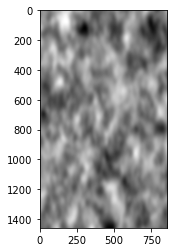

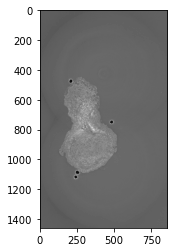

Step 100, Total loss 0.001208
Best new model! Saving...


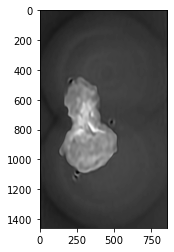

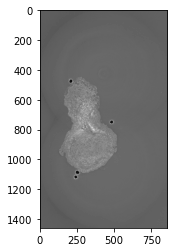

Step 200, Total loss 0.001073
Best new model! Saving...


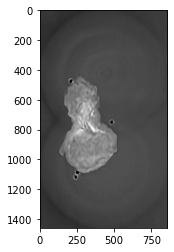

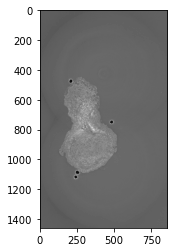

Step 300, Total loss 0.000944
Best new model! Saving...


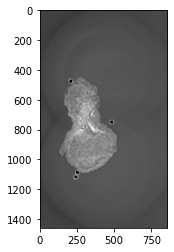

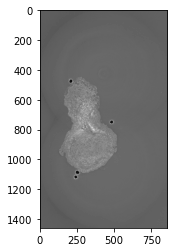

Step 400, Total loss 0.000842
Best new model! Saving...


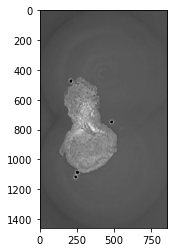

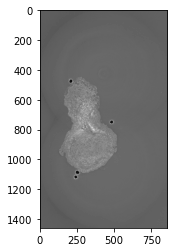

Step 500, Total loss 0.000771
Best new model! Saving...


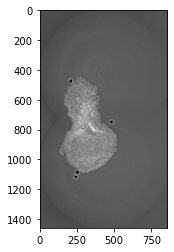

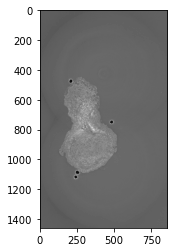

Step 600, Total loss 0.000717
Best new model! Saving...


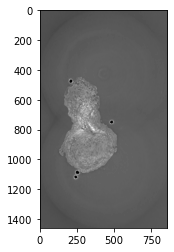

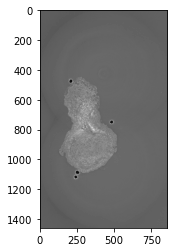

Step 700, Total loss 0.000631
Best new model! Saving...


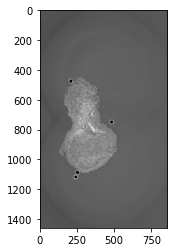

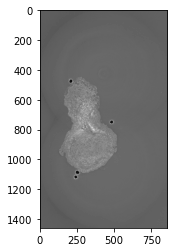

Step 800, Total loss 0.000573
Best new model! Saving...


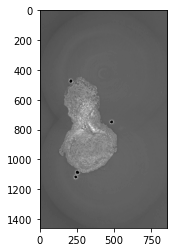

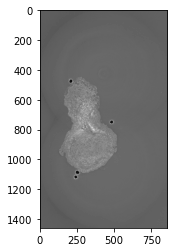

Step 900, Total loss 0.000526
Best new model! Saving...


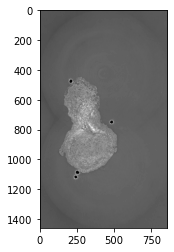

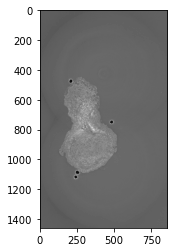

Step 1000, Total loss 0.000480
Best new model! Saving...


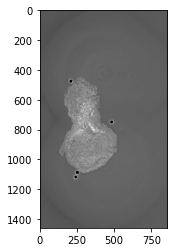

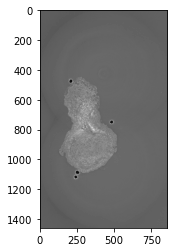

Step 1100, Total loss 0.000439
Best new model! Saving...


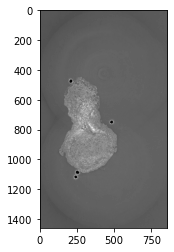

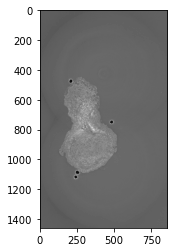

Step 1200, Total loss 0.000408
Best new model! Saving...


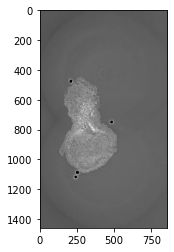

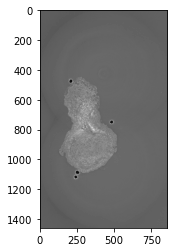

Step 1300, Total loss 0.000368
Best new model! Saving...


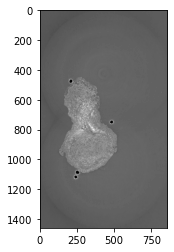

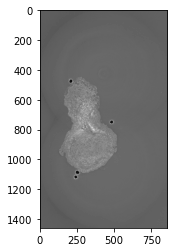

Step 1400, Total loss 0.000353
Best new model! Saving...


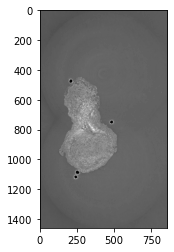

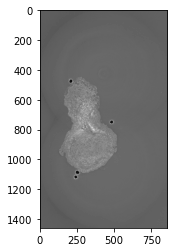

Step 1500, Total loss 0.000315
Best new model! Saving...


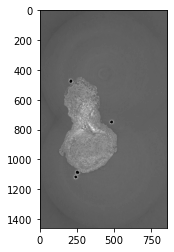

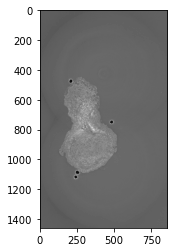

Step 1600, Total loss 0.000299
Best new model! Saving...


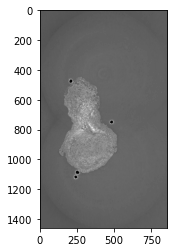

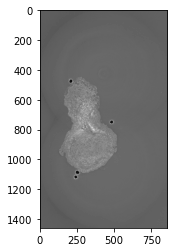

Step 1700, Total loss 0.000319


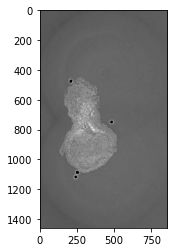

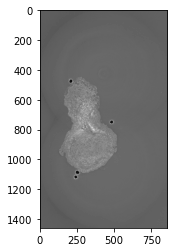

Step 1800, Total loss 0.000260
Best new model! Saving...


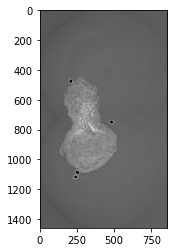

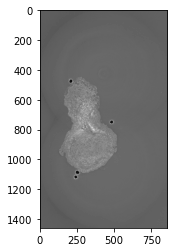

Step 1900, Total loss 0.000249
Best new model! Saving...


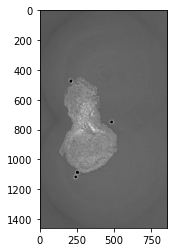

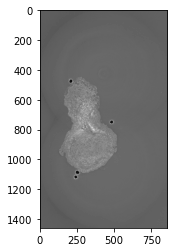

Step 2000, Total loss 0.000236
Best new model! Saving...


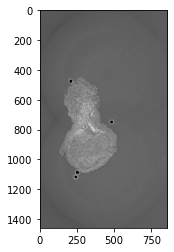

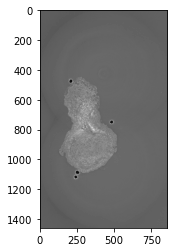

Step 2100, Total loss 0.000225
Best new model! Saving...


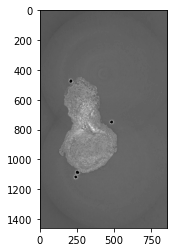

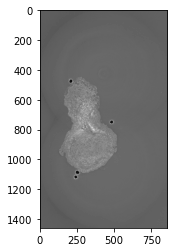

Step 2200, Total loss 0.000215
Best new model! Saving...


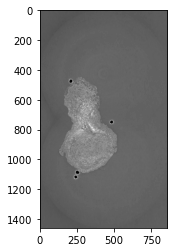

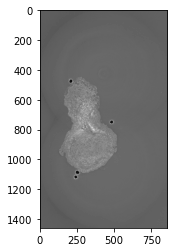

Step 2300, Total loss 0.000205
Best new model! Saving...


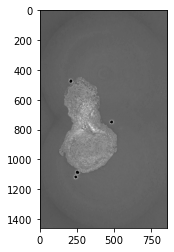

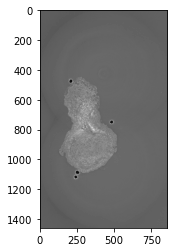

Step 2400, Total loss 0.000200
Best new model! Saving...


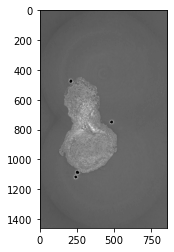

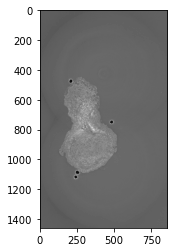

Step 2500, Total loss 0.000208


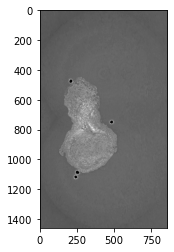

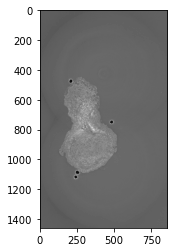

Step 2600, Total loss 0.000166
Best new model! Saving...


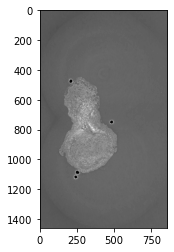

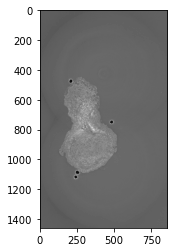

Step 2700, Total loss 0.000159
Best new model! Saving...


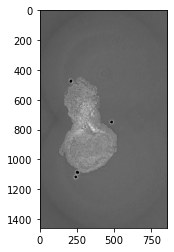

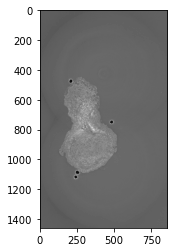

Step 2800, Total loss 0.000167


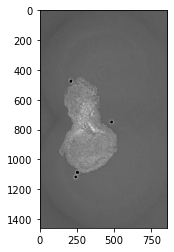

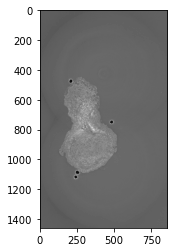

Step 2900, Total loss 0.000155
Best new model! Saving...


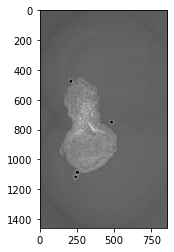

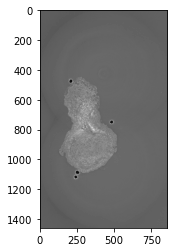

Step 3000, Total loss 0.000151
Best new model! Saving...


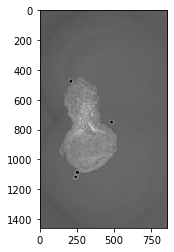

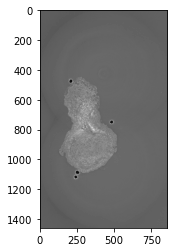

Step 3100, Total loss 0.000130
Best new model! Saving...


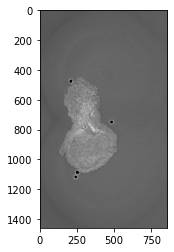

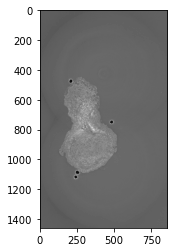

Step 3200, Total loss 0.000261


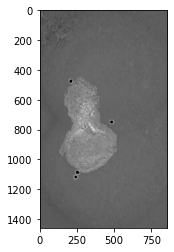

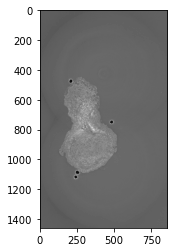

Step 3300, Total loss 0.000158


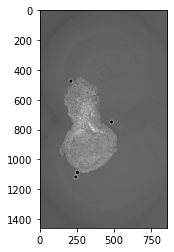

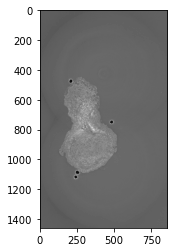

Step 3400, Total loss 0.000142


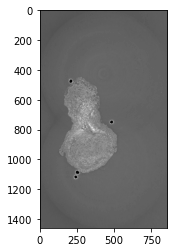

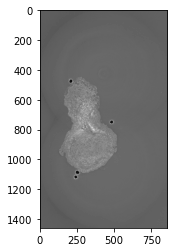

Step 3500, Total loss 0.000135


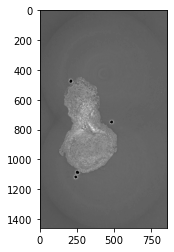

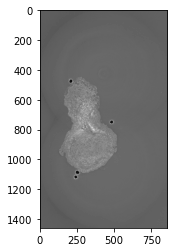

Step 3600, Total loss 0.000131


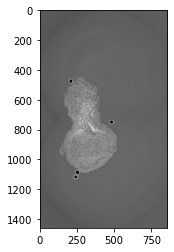

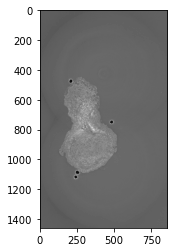

Step 3700, Total loss 0.000125
Best new model! Saving...


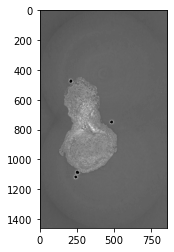

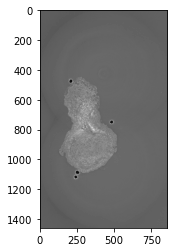

Step 3800, Total loss 0.000113
Best new model! Saving...


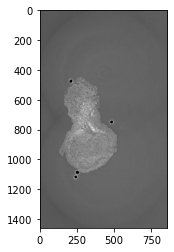

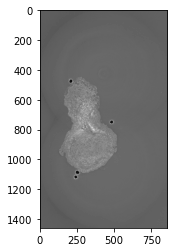

Step 3900, Total loss 0.000161


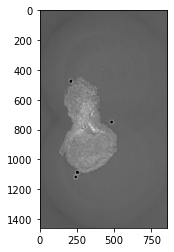

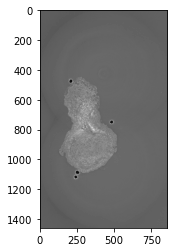

Step 4000, Total loss 0.000128


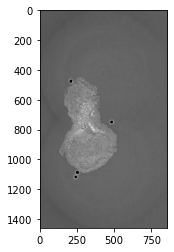

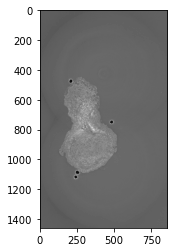

Step 4100, Total loss 0.000110
Best new model! Saving...


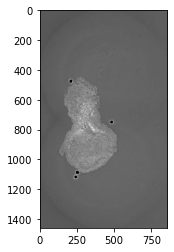

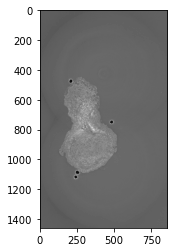

Step 4200, Total loss 0.000105
Best new model! Saving...


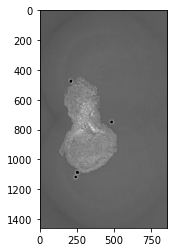

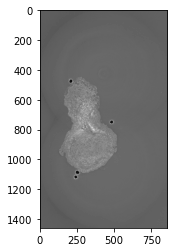

Step 4300, Total loss 0.000098
Best new model! Saving...


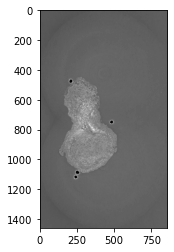

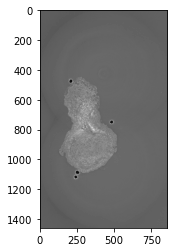

Step 4400, Total loss 0.000112


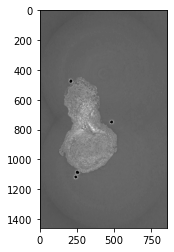

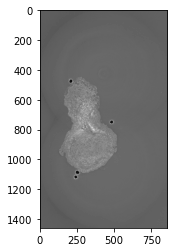

Step 4500, Total loss 0.000107


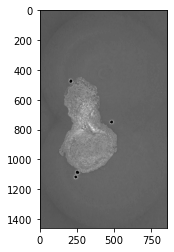

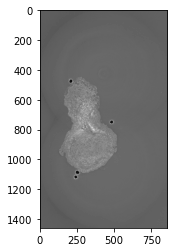

Step 4600, Total loss 0.000107


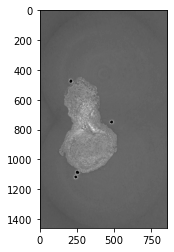

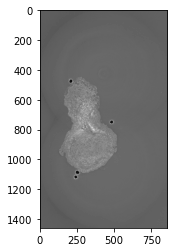

Step 4700, Total loss 0.000106


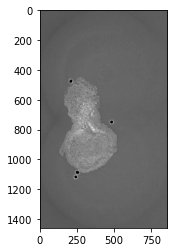

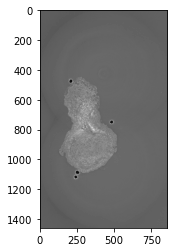

Step 4800, Total loss 0.000089
Best new model! Saving...


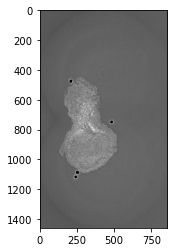

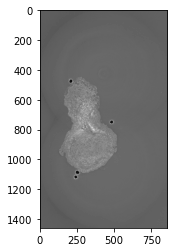

Step 4900, Total loss 0.000107


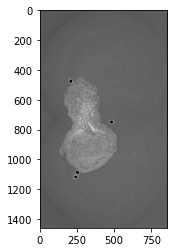

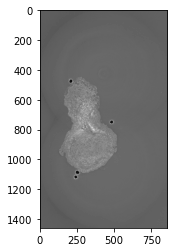

Step 5000, Total loss 0.000254


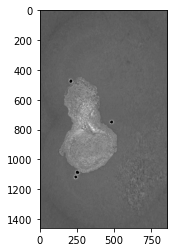

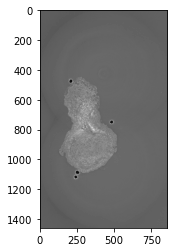

Step 5100, Total loss 0.000109


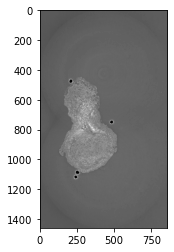

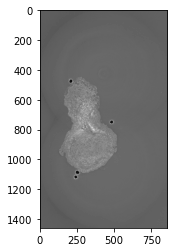

Step 5200, Total loss 0.000155


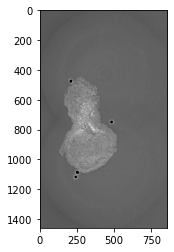

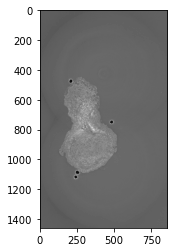

Step 5300, Total loss 0.000099


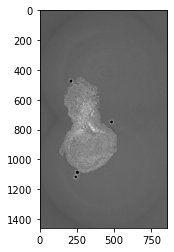

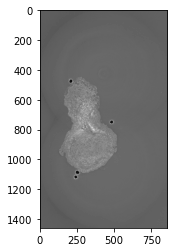

Step 5400, Total loss 0.000085
Best new model! Saving...


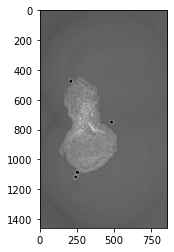

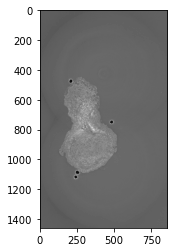

Step 5500, Total loss 0.000096


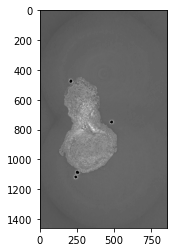

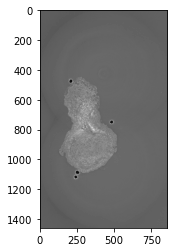

Step 5600, Total loss 0.000093


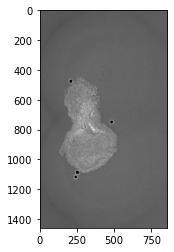

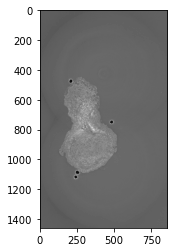

Step 5700, Total loss 0.000095


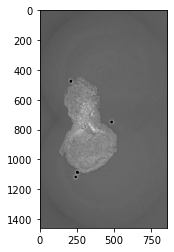

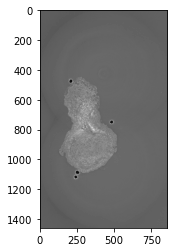

Step 5800, Total loss 0.000087


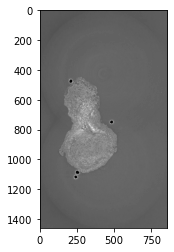

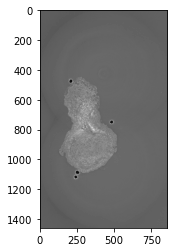

Step 5900, Total loss 0.000082
Best new model! Saving...


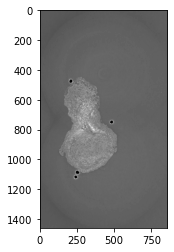

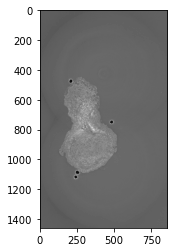

Step 6000, Total loss 0.000173


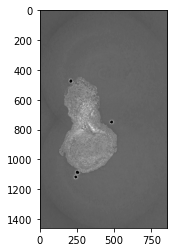

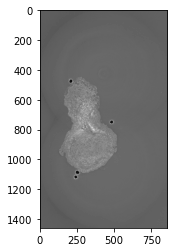

Step 6100, Total loss 0.000095


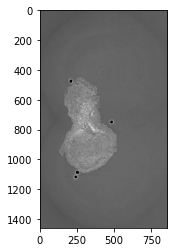

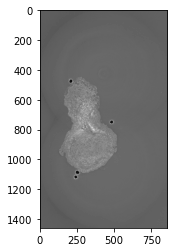

Step 6200, Total loss 0.000110


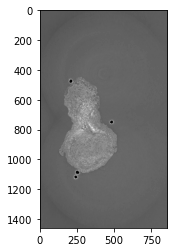

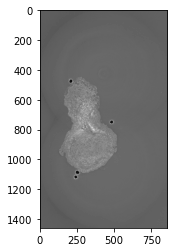

Step 6300, Total loss 0.000193


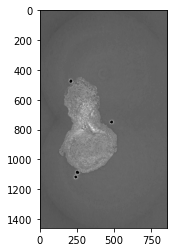

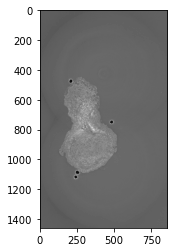

Step 6400, Total loss 0.000075
Best new model! Saving...


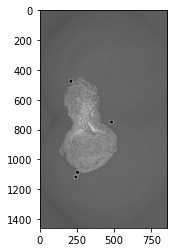

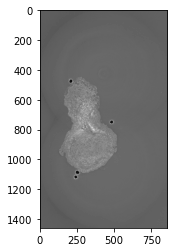

Step 6500, Total loss 0.000092


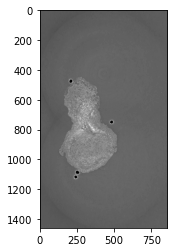

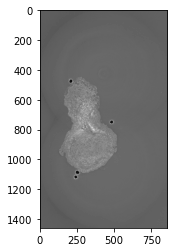

Step 6600, Total loss 0.000208


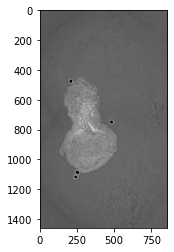

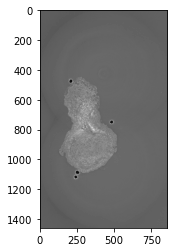

Step 6700, Total loss 0.000074
Best new model! Saving...


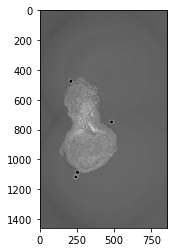

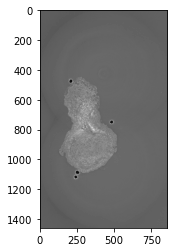

Step 6800, Total loss 0.000069
Best new model! Saving...


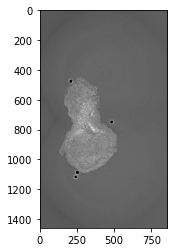

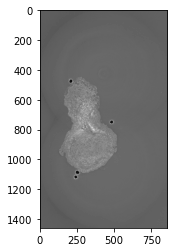

Step 6900, Total loss 0.000083


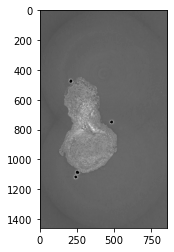

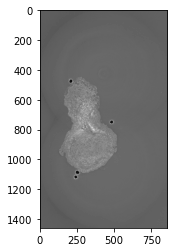

Step 7000, Total loss 0.000068
Best new model! Saving...


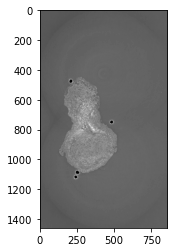

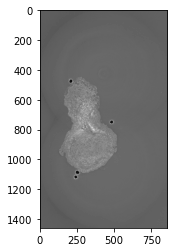

Step 7100, Total loss 0.000065
Best new model! Saving...


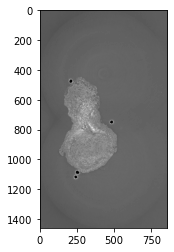

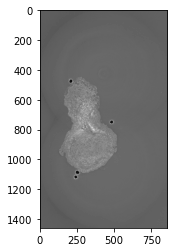

Step 7200, Total loss 0.000087


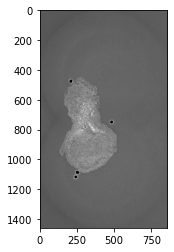

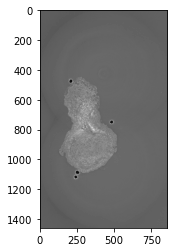

Step 7300, Total loss 0.000079


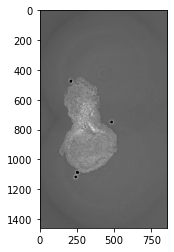

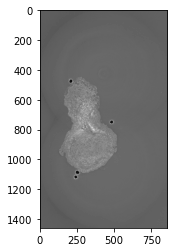

Step 7400, Total loss 0.000081


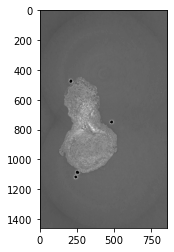

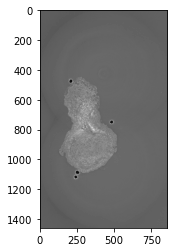

Step 7500, Total loss 0.000061
Best new model! Saving...


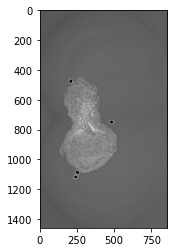

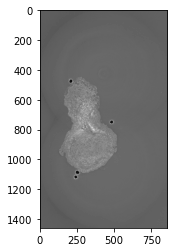

Step 7600, Total loss 0.000069


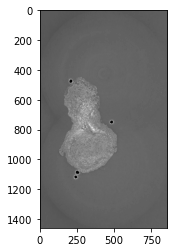

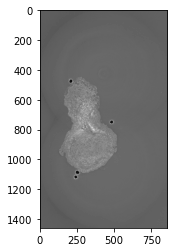

Step 7700, Total loss 0.000083


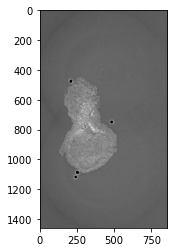

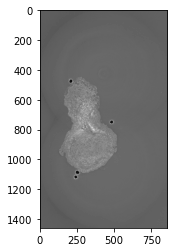

Step 7800, Total loss 0.000129


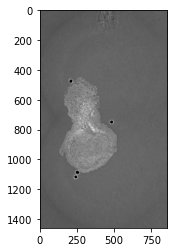

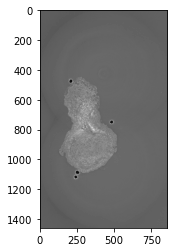

Step 7900, Total loss 0.000089


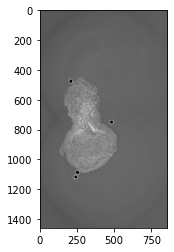

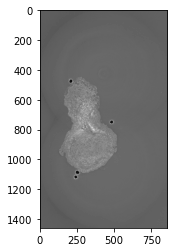

Step 8000, Total loss 0.000077


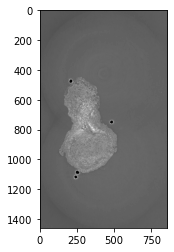

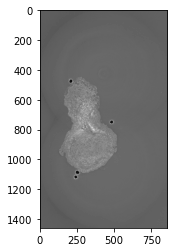

Step 8100, Total loss 0.000092


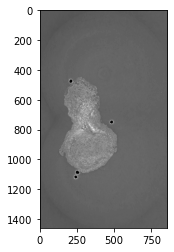

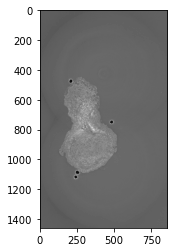

Step 8200, Total loss 0.000116


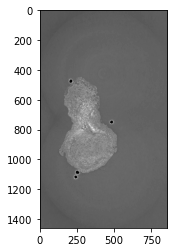

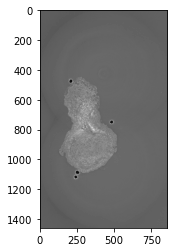

Step 8300, Total loss 0.000068


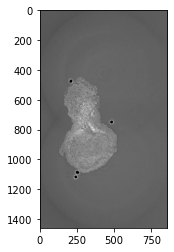

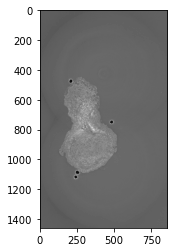

Step 8400, Total loss 0.000130


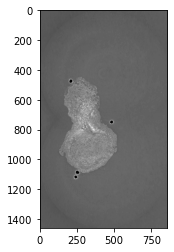

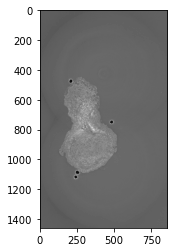

Step 8500, Total loss 0.000060
Best new model! Saving...


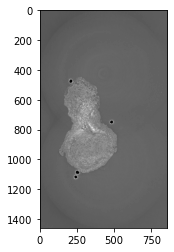

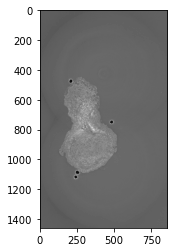

Step 8600, Total loss 0.000083


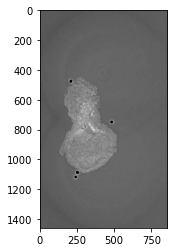

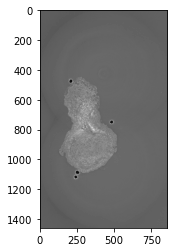

Step 8700, Total loss 0.000071


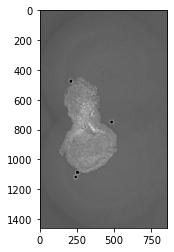

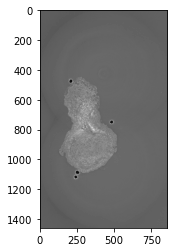

Step 8800, Total loss 0.000058
Best new model! Saving...


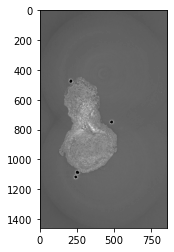

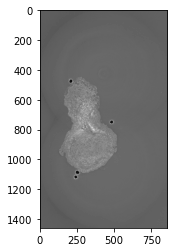

Step 8900, Total loss 0.000092


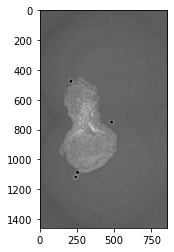

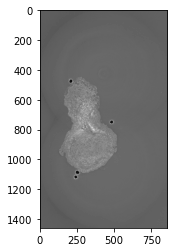

Step 9000, Total loss 0.000076


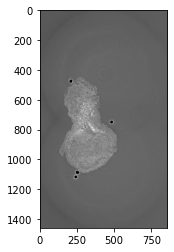

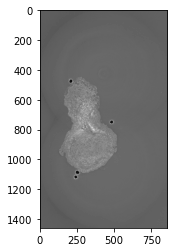

Step 9100, Total loss 0.000062


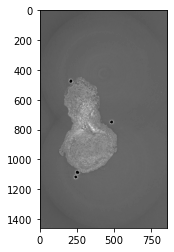

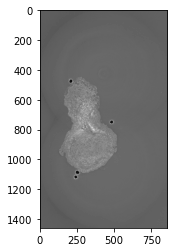

Step 9200, Total loss 0.000077


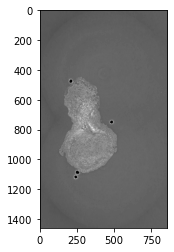

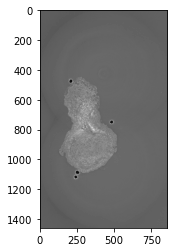

Step 9300, Total loss 0.000091


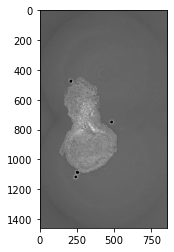

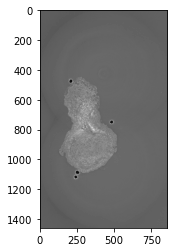

Step 9400, Total loss 0.000065


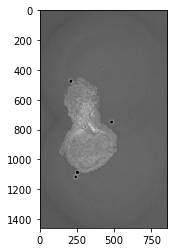

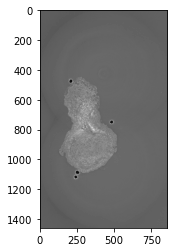

Step 9500, Total loss 0.000155


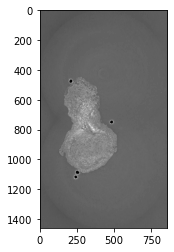

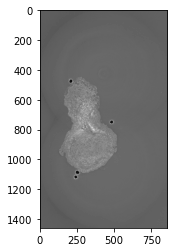

Step 9600, Total loss 0.000071


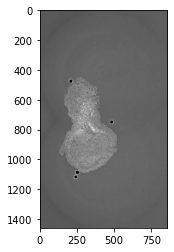

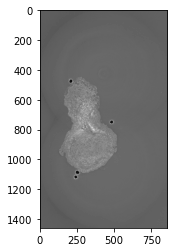

Step 9700, Total loss 0.000154


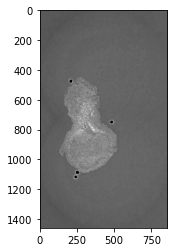

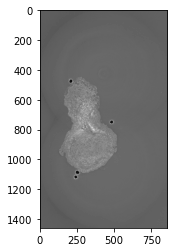

Step 9800, Total loss 0.000067


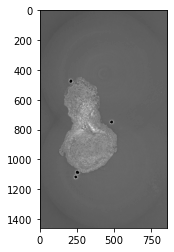

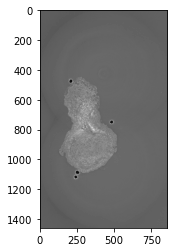

Step 9900, Total loss 0.000138


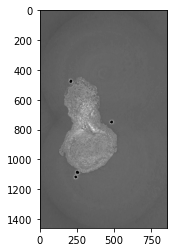

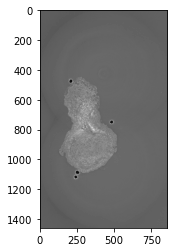

In [ ]:
from torchinfo import summary

filename = "./174_tumor_Nr56_x4_StitchPag_stitch_2563x4381x2162-11396.tif"

# Empty CUDA cache
torch.cuda.empty_cache()

# Import dataset
dataset = MicroCTSingleImage(filename,3)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)
img, coords = next(iter(dataloader))

print(coords.shape)

print("Input size in MB: ", (coords.element_size() * coords.nelement()) / (1024**2))

# Import model
model = Siren(in_features=2, out_features=1, hidden_features=384, hidden_layers=4, outermost_linear=True)

# Move model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print("Beginning mem: ", torch.cuda.memory_allocated(device))
model.to(device)
# print("1. After Model to Device: ", torch.cuda.memory_allocated(device) / (1024**2))

# Train model
model = train_siren(model, dataloader, total_steps=10000, lr=1e-4, steps_til_summary=100, device=device, checkpoint_path=f'{filename[-9:-4]}_checkpoint.pt')

In [16]:
# Load trained model from checkpoint for evaluation
PATH = "11396_checkpoint.pt"
model = Siren(in_features=2, out_features=1, hidden_features=384, hidden_layers=4, outermost_linear=True)

model.load_state_dict(torch.load(PATH))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.cuda.empty_cache()

model.eval()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=384, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=384, out_features=384, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=384, out_features=384, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=384, out_features=384, bias=True)
    )
    (4): SineLayer(
      (linear): Linear(in_features=384, out_features=384, bias=True)
    )
    (5): Linear(in_features=384, out_features=1, bias=True)
  )
)

The resulting MSE: 0.000377 and PSNR: 34.235291417831185


tensor([[0.3633],
        [0.3557],
        [0.3530],
        ...,
        [0.3744],
        [0.3757],
        [0.3792]])

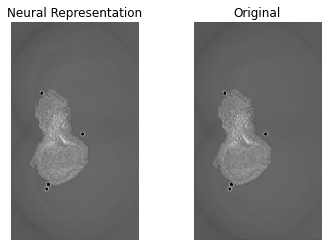

In [17]:
# Load image again in original resolution
dataset = MicroCTSingleImage(filename, 1)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)
img, coords = next(iter(dataloader))

evaluate_siren_partial(model, img, coords, device, imagepath='pred_original_res.png')

In [ ]:
filename = "./174_tumor_Nr56_x4_StitchPag_stitch_2563x4381x2162-11396.tif"

# Import dataset in original resolution
dataset = MicroCTSingleImage(filename, 1)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

# Import model
model = Siren(in_features=2, out_features=1, hidden_features=384, hidden_layers=4, outermost_linear=True)

# Move model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.cuda.empty_cache()

# Train model
model = train_siren_rand_samples_improved(model, dataloader, sampling_frequency=500, total_steps=15000, lr=1e-4, steps_til_summary=100, n_samples=2200000, device=device, checkpoint_path=f'{filename[-9:-4]}_checkpoint_rand_samp.pt')

Step 0, Total loss 0.011700
Best new model! Saving...
Step 100, Total loss 0.001268
Best new model! Saving...
Step 200, Total loss 0.001079
Best new model! Saving...
Step 300, Total loss 0.000946
Best new model! Saving...
Step 400, Total loss 0.000840
Best new model! Saving...
Step 500, Total loss 0.000776
Best new model! Saving...
Step 600, Total loss 0.000690
Best new model! Saving...
Step 700, Total loss 0.000627
Best new model! Saving...
Step 800, Total loss 0.000581
Best new model! Saving...
Step 900, Total loss 0.000522
Best new model! Saving...
Step 1000, Total loss 0.000525
Step 1100, Total loss 0.000423
Best new model! Saving...
Step 1200, Total loss 0.000396
Best new model! Saving...
Step 1300, Total loss 0.000391
Best new model! Saving...
Step 1400, Total loss 0.000352
Best new model! Saving...
Step 1500, Total loss 0.000387
Step 1600, Total loss 0.000309
Best new model! Saving...
Step 1700, Total loss 0.000287
Best new model! Saving...
Step 1800, Total loss 0.000270
Best ne

In [7]:
filename = "./174_tumor_Nr56_x4_StitchPag_stitch_2563x4381x2162-11396.tif"

# Load trained model from checkpoint for evaluation
PATH = "11396_checkpoint_rand_samp.pt"
model = Siren(in_features=2, out_features=1, hidden_features=384, hidden_layers=4, outermost_linear=True)

model.load_state_dict(torch.load(PATH))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.cuda.empty_cache()

model.eval()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=384, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=384, out_features=384, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=384, out_features=384, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=384, out_features=384, bias=True)
    )
    (4): SineLayer(
      (linear): Linear(in_features=384, out_features=384, bias=True)
    )
    (5): Linear(in_features=384, out_features=1, bias=True)
  )
)

The resulting MSE: 0.000153 and PSNR: 38.14175415267447


tensor([[0.0531],
        [0.0855],
        [0.2389],
        ...,
        [0.1687],
        [0.1755],
        [0.1888]])

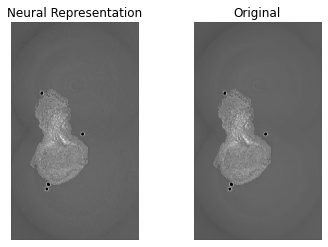

In [10]:
# Load image again in original resolution
dataset = MicroCTSingleImage(filename, 1)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)
img, coords = next(iter(dataloader))

evaluate_siren_partial(model, img, coords, device, imagepath='pred_original_res.png')